In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ========================
#  PHYSICAL CONSTANTS
# ========================
GRAVITY = 9.80665  # m/s² [1]
RHO_SEA_LEVEL = 1.225  # kg/m³ [1]

# ========================
#  HELPER FUNCTIONS
# ========================
def quaternion_to_rotation_matrix(q):
    """Convert unit quaternion [w, x, y, z] to 3x3 rotation matrix"""
    w, x, y, z = q
    return np.array([
        [1-2*(y**2+z**2), 2*(x*y-w*z), 2*(x*z+w*y)],
        [2*(x*y+w*z), 1-2*(x**2+z**2), 2*(y*z-w*x)],
        [2*(x*z-w*y), 2*(y*z+w*x), 1-2*(x**2+y**2)]
    ])

def quaternion_multiply(q1, q2):
    """Hamilton product of two quaternions"""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

# ========================
#  CORE SIMULATION
# ========================
def rocket_dynamics(t, y, params):
    """6DOF equations of motion for rocket with canards"""
    # ------ State unpacking ------
    # Position [m], velocity [m/s], quaternion, angular velocity [rad/s]
    pos = y[0:3]
    vel = y[3:6]
    q = y[6:10]
    omega = y[10:13]
    
    # ------ Force calculations ------
    # Atmospheric properties
    altitude = pos[2]
    rho = RHO_SEA_LEVEL * np.exp(-altitude/8500)  # Exponential model [1]
    wind = np.array([5*(1 - np.exp(-altitude/1000)), 0, 0])  # Eastward wind
    
    # Current mass properties
    current_mass = params['dry_mass'] + fuel_mass(t, params)
    I_body = params['I_body']  # Simplified constant inertia
    
    # Orientation transforms
    R = quaternion_to_rotation_matrix(q)  # Body->World
    v_air_body = R.T @ (vel - wind)  # Air-relative velocity in body frame
    
    # ------ Aerodynamic forces ------
    # Main body drag (simplified)
    Cd_body = 0.5
    A_ref = 0.1**2 * np.pi
    drag_body = -0.5 * rho * np.linalg.norm(v_air_body) * v_air_body * Cd_body * A_ref
    
    # Canard forces (4 canards at 0°, 90°, 180°, 270° azimuth)
    canard_forces = np.zeros(3)
    canard_moments = np.zeros(3)
    for i, delta in enumerate(params['canard_angles']):
        # Canard parameters
        azimuth = i * np.pi/2  # 0, π/2, π, 3π/2
        position = np.array([-1.5, 0, 0])  # 1.5m behind CoM
        area = 0.05  # m²
        
        # Effective angle of attack [2]
        alpha = np.arctan2(v_air_body[2], v_air_body[0]) 
        beta = np.arcsin(v_air_body[1]/np.linalg.norm(v_air_body))
        alpha_eff = alpha + delta * np.cos(azimuth)
        beta_eff = beta + delta * np.sin(azimuth)
        
        # Lift/drag coefficients (simplified)
        Cl = 1.2 * np.sin(2*alpha_eff)
        Cd = 0.3 + 0.5*(1 - np.cos(2*alpha_eff))
        
        # Local forces
        L = 0.5 * rho * Cl * area * np.linalg.norm(v_air_body)**2
        D = 0.5 * rho * Cd * area * np.linalg.norm(v_air_body)**2
        F_local = np.array([
            -D*np.cos(alpha_eff) + L*np.sin(alpha_eff),
            D*np.sin(beta_eff),
            D*np.sin(alpha_eff) + L*np.cos(alpha_eff)
        ])
        
        # Transform to body frame and sum
        canard_forces += F_local
        canard_moments += np.cross(position, F_local)
    
    # ------ Total forces/moments ------
    F_thrust_body = np.array([params['thrust'](t), 0, 0])
    F_gravity_body = R.T @ np.array([0, 0, -current_mass*GRAVITY])
    F_total_body = F_thrust_body + drag_body + canard_forces + F_gravity_body
    
    M_total_body = canard_moments - 0.1 * omega  # Simple damping
    
    # ------ Equations of motion ------
    # Linear acceleration
    a_world = R @ (F_total_body / current_mass)
    
    # Angular acceleration (quaternion formulation) [3]
    q_dot = 0.5 * quaternion_multiply(q, [0, *omega])
    omega_dot = np.linalg.inv(I_body) @ (M_total_body - np.cross(omega, I_body @ omega))
    
    return np.concatenate([vel, a_world, q_dot, omega_dot])

# ========================
#  SIMULATION SETUP
# ========================
def fuel_mass(t, params):
    """Linear fuel burn model"""
    return max(params['fuel_initial'] - params['burn_rate']*t, 0)

def thrust_profile(t):
    """Sample thrust curve (Newtons)"""
    if t < 0.5: return 15000 * t/0.5
    elif t < 3: return 15000
    else: return 15000 * (4 - t)/1.0

params = {
    'dry_mass': 50,          # kg
    'fuel_initial': 20,      # kg
    'burn_rate': 6.67,       # kg/s (for 3s burn)
    'I_body': np.diag([60, 60, 5]),  # kg·m²
    'thrust': thrust_profile,
    'canard_angles': np.radians([5, -5, 5, -5])  # Differential deflections
}

# Initial conditions: [pos, vel, quaternion, omega]
y0 = np.concatenate([
    np.zeros(3),            # Position (m)
    np.zeros(3),            # Velocity (m/s)
    np.array([1, 0, 0, 0]), # Quaternion (no rotation)
    np.zeros(3)             # Angular velocity (rad/s)
])

# ========================
#  RUN SIMULATION
# ========================
sol = solve_ivp(rocket_dynamics, [0, 20], y0, args=(params,),
                method='RK45', max_step=0.01)

# ========================
#  VISUALIZATION
# ========================
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sol.y[0], sol.y[1], sol.y[2])
ax.set(xlabel='East (m)', ylabel='North (m)', zlabel='Altitude (m)',
       title='Rocket Trajectory with Canard Control')
plt.show()


/var/folders/tg/1rvyy6v13kq9w3s_hnykjpmc0000gp/T/ipykernel_75220/1019509650.py:78: RuntimeWarning: invalid value encountered in scalar divide
  beta = np.arcsin(v_air_body[1]/np.linalg.norm(v_air_body))


KeyboardInterrupt: 

/Users/guilhermegarcia/miniconda3/envs/summer2024/lib/python3.12/site-packages/numpy/core/numeric.py:1647: RuntimeWarning: overflow encountered in multiply
  multiply(a1, b2, out=cp0)
/Users/guilhermegarcia/miniconda3/envs/summer2024/lib/python3.12/site-packages/numpy/core/numeric.py:1648: RuntimeWarning: overflow encountered in multiply
  tmp = array(a2 * b1)
/Users/guilhermegarcia/miniconda3/envs/summer2024/lib/python3.12/site-packages/numpy/core/numeric.py:1649: RuntimeWarning: invalid value encountered in subtract
  cp0 -= tmp
/Users/guilhermegarcia/miniconda3/envs/summer2024/lib/python3.12/site-packages/numpy/core/numeric.py:1650: RuntimeWarning: overflow encountered in multiply
  multiply(a2, b0, out=cp1)
/Users/guilhermegarcia/miniconda3/envs/summer2024/lib/python3.12/site-packages/numpy/core/numeric.py:1651: RuntimeWarning: overflow encountered in multiply
  multiply(a0, b2, out=tmp)
/Users/guilhermegarcia/miniconda3/envs/summer2024/lib/python3.12/site-packages/numpy/core/numer

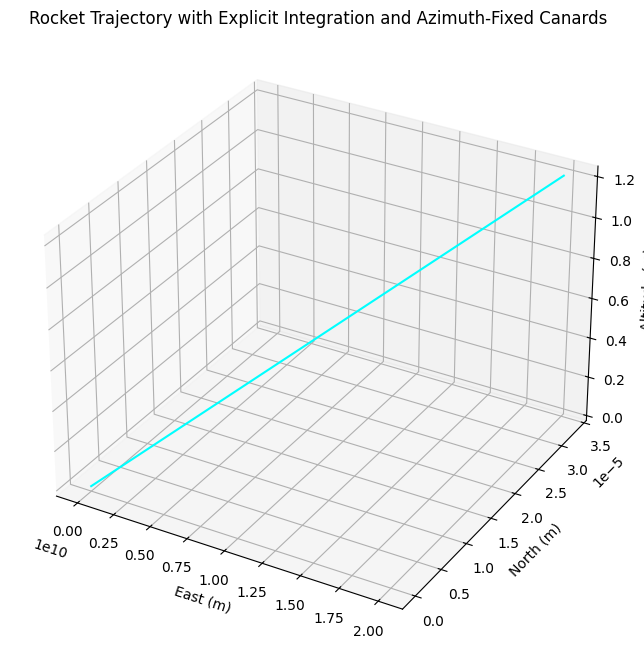

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
GRAVITY = 9.80665  # m/s^2
RHO_SEA_LEVEL = 1.225  # kg/m^3
ROCKET_RADIUS = 0.1  # meters

# Quaternion to rotation matrix
def quaternion_to_rotation_matrix(q):
    w, x, y, z = q
    return np.array([
        [1-2*(y**2+z**2), 2*(x*y-w*z), 2*(x*z+w*y)],
        [2*(x*y+w*z), 1-2*(x**2+z**2), 2*(y*z-w*x)],
        [2*(x*z-w*y), 2*(y*z+w*x), 1-2*(x**2+y**2)]
    ])

# Quaternion multiplication
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

# Normalize quaternion
def normalize_quaternion(q):
    return q / np.linalg.norm(q)

# Axis-angle rotation matrix
def axis_angle_rotation(axis, theta):
    axis = axis / np.linalg.norm(axis)
    a = np.cos(theta / 2)
    b, c, d = -axis * np.sin(theta / 2)
    return np.array([
        [a*a + b*b - c*c - d*d, 2*(b*c - a*d), 2*(b*d + a*c)],
        [2*(b*c + a*d), a*a + c*c - b*b - d*d, 2*(c*d - a*b)],
        [2*(b*d - a*c), 2*(c*d + a*b), a*a + d*d - b*b - c*c]
    ])

# Fuel mass model
def fuel_mass(t, params):
    return max(params['fuel_initial'] - params['burn_rate'] * t, 0)

# Thrust profile
def thrust_profile(t):
    if t < 3:
        return 15000
    elif t < 4:
        return 15000 * (4 - t)
    else:
        return 0

# Rocket dynamics function
def rocket_dynamics_explicit(t, y, params):
    pos = y[0:3]
    vel = y[3:6]
    q = y[6:10]
    omega = y[10:13]

    altitude = pos[2]
    rho = RHO_SEA_LEVEL * np.exp(-altitude / 8500)
    wind = np.array([5 * (1 - np.exp(-altitude / 1000)), 0, 0])

    current_mass = params['dry_mass'] + fuel_mass(t, params)
    I_body = params['I_body']

    R = quaternion_to_rotation_matrix(q)
    v_air_body = R.T @ (vel - wind)
    v_mag = np.linalg.norm(v_air_body)
    if v_mag < 1e-6:
        v_mag = 1e-6

    # Aerodynamic angles
    alpha = np.arctan2(v_air_body[2], v_air_body[0])
    beta = np.arcsin(v_air_body[1] / v_mag)

    # Main body drag
    drag_body = -0.5 * rho * v_mag * v_air_body * params['Cd_body'] * params['A_ref']

    F_total = np.zeros(3)
    M_total = np.zeros(3)

    for i, delta in enumerate(params['canard_angles']):
        azimuth = i * np.pi / 2
        x_pos = -1.5
        y_pos = ROCKET_RADIUS * np.cos(azimuth)
        z_pos = ROCKET_RADIUS * np.sin(azimuth)
        position = np.array([x_pos, y_pos, z_pos])

        radial_axis = np.array([0, np.cos(azimuth), np.sin(azimuth)])

        R_canard = axis_angle_rotation(radial_axis, delta)

        alpha_eff = alpha + delta
        Cl = 1.2 * np.sin(2 * alpha_eff)
        Cd = 0.3 + 0.5 * (1 - np.cos(2 * alpha_eff))

        L = 0.5 * rho * Cl * params['A_canard'] * v_mag**2
        D = 0.5 * rho * Cd * params['A_canard'] * v_mag**2

        F_local = np.array([
            -D * np.cos(alpha_eff) + L * np.sin(alpha_eff),
            0,
            D * np.sin(alpha_eff) + L * np.cos(alpha_eff)
        ])

        F_body = R_canard @ F_local
        F_total += F_body
        M_total += np.cross(position, F_body)

    F_thrust = np.array([params['thrust'](t), 0, 0])
    F_gravity = R.T @ np.array([0, 0, -current_mass * GRAVITY])
    F_total += F_thrust + drag_body + F_gravity

    a_world = R @ (F_total / current_mass)
    q_dot = 0.5 * quaternion_multiply(q, np.concatenate(([0], omega)))
    omega_dot = np.linalg.inv(I_body) @ (M_total - np.cross(omega, I_body @ omega))

    return np.concatenate([vel, a_world, q_dot, omega_dot])

# Explicit integration simulation
def run_explicit_simulation(params, dt=0.01, t_final=20):
    n_steps = int(t_final / dt) + 1
    state = np.zeros((13, n_steps))
    state[:, 0] = np.concatenate([
        np.zeros(3),
        np.zeros(3),
        np.array([1, 0, 0, 0]),
        np.zeros(3)
    ])
    t = 0
    for i in range(1, n_steps):
        y = state[:, i-1]
        dydt = rocket_dynamics_explicit(t, y, params)
        state[:, i] = y + dydt * dt
        state[6:10, i] = normalize_quaternion(state[6:10, i])
        t += dt
    return state

# Parameters
params = {
    'dry_mass': 50,
    'fuel_initial': 20,
    'burn_rate': 6.67,
    'I_body': np.diag([60, 60, 5]),
    'Cd_body': 0.5,
    'A_ref': np.pi * (0.1)**2,
    'A_canard': 0.05,
    'thrust': thrust_profile,
    'canard_angles': np.radians([0, 0, 0, 0])
}

# Run simulation
state = run_explicit_simulation(params)

# Plot trajectory
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(state[0], state[1], state[2], color='cyan')
ax.set(xlabel='East (m)', ylabel='North (m)', zlabel='Altitude (m)',
       title='Rocket Trajectory with Explicit Integration and Azimuth-Fixed Canards')
plt.show()


/var/folders/tg/1rvyy6v13kq9w3s_hnykjpmc0000gp/T/ipykernel_75220/806174184.py:71: RuntimeWarning: invalid value encountered in scalar divide
  beta = np.arcsin(v_air_body[1]/v_mag)


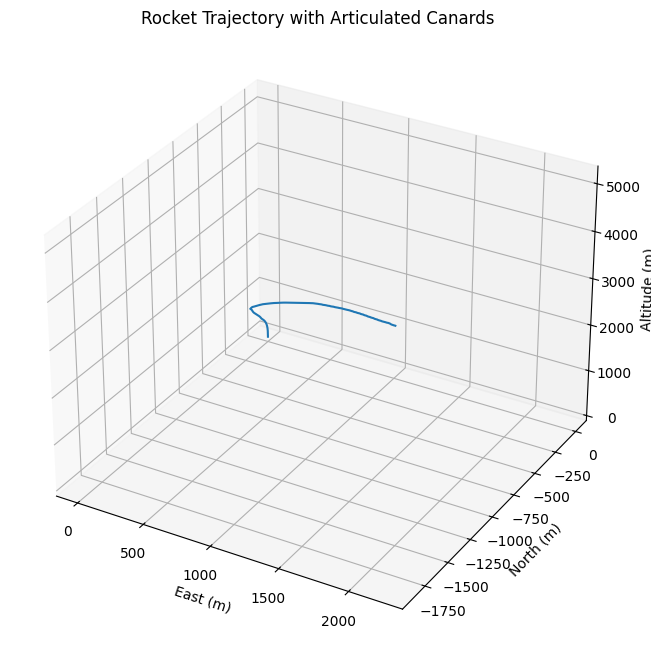

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ========================
#  CONSTANTS & PARAMETERS
# ========================
GRAVITY = 9.80665       # m/s²
RHO_SEA_LEVEL = 1.225   # kg/m³
ROCKET_RADIUS = 0.1     # meters
NUM_CANARDS = 4         # Evenly spaced around circumference

# ========================
#  QUATERNION OPERATIONS
# ========================
def quaternion_to_rotation_matrix(q):
    w, x, y, z = q
    return np.array([
        [1-2*(y**2+z**2), 2*(x*y-w*z), 2*(x*z+w*y)],
        [2*(x*y+w*z), 1-2*(x**2+z**2), 2*(y*z-w*x)],
        [2*(x*z-w*y), 2*(y*z+w*x), 1-2*(x**2+y**2)]
    ])

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def normalize_quaternion(q):
    return q / np.linalg.norm(q)

# ========================
#  CANARD DYNAMICS
# ========================
def calculate_canard_forces(params, v_air_body, R, altitude, q, omega):
    rho = RHO_SEA_LEVEL * np.exp(-altitude/8500)
    F_total = np.zeros(3)
    M_total = np.zeros(3)
    
    for i in range(NUM_CANARDS):
        # Canard positioning
        azimuth = i * 2*np.pi/NUM_CANARDS
        x_pos = -1.5  # 1.5m behind CoM
        y_pos = ROCKET_RADIUS * np.cos(azimuth)
        z_pos = ROCKET_RADIUS * np.sin(azimuth)
        position = np.array([x_pos, y_pos, z_pos])
        
        # Rotation axis (radial direction from rocket centerline)
        radial_axis = np.array([0, np.cos(azimuth), np.sin(azimuth)])
        radial_axis /= np.linalg.norm(radial_axis)
        
        # Current deflection angle (from control system or fixed)
        delta = params['canard_deflections'][i]
        
        # Rotation matrix for deflection
        cd = np.cos(delta)
        sd = np.sin(delta)
        R_deflection = np.array([
            [cd, -sd*radial_axis[2], sd*radial_axis[1]],
            [sd*radial_axis[2], cd, -sd*radial_axis[0]],
            [-sd*radial_axis[1], sd*radial_axis[0], cd]
        ])
        
        # Effective angle of attack calculation
        v_mag = np.linalg.norm(v_air_body)
        alpha = np.arctan2(v_air_body[2], v_air_body[0]) + delta
        beta = np.arcsin(v_air_body[1]/v_mag)
        
        # Aerodynamic coefficients
        Cl = 1.2 * np.sin(2*alpha)
        Cd = 0.3 + 0.5*(1 - np.cos(2*alpha))
        
        # Local forces (canard frame)
        L = 0.5 * rho * Cl * params['A_canard'] * v_mag**2
        D = 0.5 * rho * Cd * params['A_canard'] * v_mag**2
        F_local = np.array([-D, 0, L])
        
        # Transform to body frame and apply deflection
        F_body = R_deflection @ F_local
        F_total += F_body
        M_total += np.cross(position, F_body)
    
    return F_total, M_total

# ========================
#  MAIN SIMULATION LOOP
# ========================
def rocket_simulation(params, dt=0.01, t_final=10000):
    n_steps = int(t_final/dt) + 1
    state = np.zeros((13, n_steps))
    
    # Initial orientation: vertical launch (x_body aligned with world z)
    theta = -np.pi/2  # -90° rotation about y-axis
    q0 = np.array([np.cos(theta/2), 0, np.sin(theta/2), 0])
    state[:,0] = np.concatenate([
        np.zeros(3),      # Position (world frame)
        np.zeros(3),      # Velocity (world frame)
        q0,               # Orientation quaternion
        np.zeros(3)       # Angular velocity (body frame)
    ])
    
    for i in range(1, n_steps):
        t = (i-1)*dt
        y_prev = state[:,i-1]
        
        # Unpack state
        pos = y_prev[0:3]
        vel = y_prev[3:6]
        q = y_prev[6:10]
        omega = y_prev[10:13]
        
        # Current mass properties
        mass = params['dry_mass'] + max(params['fuel_initial'] - params['burn_rate']*t, 0)
        I_body = params['I_body']
        
        # Transformations
        R = quaternion_to_rotation_matrix(q)
        v_air_body = R.T @ vel  # Simplified wind model
        
        # Calculate forces
        F_thrust = np.array([params['thrust'](t), 0, 0])
        F_gravity_body = R.T @ np.array([0, 0, -mass*GRAVITY])
        F_canards, M_canards = calculate_canard_forces(params, v_air_body, R, pos[2], q, omega)
        
        # Total forces/moments
        F_total = F_thrust + F_gravity_body + F_canards
        M_total = M_canards - 0.1*omega  # Simple damping
        
        # Equations of motion
        a_world = R @ (F_total / mass)
        q_dot = 0.5 * quaternion_multiply(q, np.concatenate(([0], omega)))
        omega_dot = np.linalg.inv(I_body) @ (M_total - np.cross(omega, I_body @ omega))
        
        # Euler integration
        state[0:3,i] = pos + vel*dt
        state[3:6,i] = vel + a_world*dt
        state[6:10,i] = normalize_quaternion(q + q_dot*dt)
        state[10:13,i] = omega + omega_dot*dt
    
    return state

# ========================
#  SETUP & EXECUTION
# ========================
params = {
    'dry_mass': 50,
    'fuel_initial': 20,
    'burn_rate': 6.67,
    'I_body': np.diag([60, 60, 5]),
    'A_canard': 0.05,
    'thrust': lambda t: 15000 if t < 3 else 15000*(4-t)/1,
    'canard_deflections': np.radians([5, -5, 5, -5])  # Individual deflections
}

results = rocket_simulation(params)

# ========================
#  3D VISUALIZATION
# ========================
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(results[0], results[1], results[2])
ax.set(xlabel='East (m)', ylabel='North (m)', zlabel='Altitude (m)',
       title='Rocket Trajectory with Articulated Canards')
plt.show()
